# AutoRegression Time Series Forecasting Method
# AUTOREG MODEL PIPELINE

- This code automatically downloads the last two years of Silver Futures (SI=F) data using Yahoo Finance and prepares it for time-series forecasting.
- It intelligently selects the best prediction AutoReg statistical method—based on real performance metrics.
- The selected model analyzes price movement patterns, volatility behavior, seasonal trends, and momentum shifts to forecast the next 15 days of TATACONSUM prices.
- A clear visualization graph overlays both the real historical trend and the model’s future predictions, making comparison intuitive and insight-ful.

                                  Open         High          Low        Close  \
Date                                                                            
2024-01-01 00:00:00+05:30  1078.368009  1078.368009  1060.770676  1064.812622   
2024-01-02 00:00:00+05:30  1070.974097  1087.437802  1064.221074  1082.212769   
2024-01-03 00:00:00+05:30  1082.409874  1083.543621  1067.375718  1069.593872   
2024-01-04 00:00:00+05:30  1072.699249  1112.626021  1070.776898  1109.619263   
2024-01-05 00:00:00+05:30  1109.077063  1115.140042  1101.239634  1107.056030   
...                                ...          ...          ...          ...   
2024-12-27 00:00:00+05:30   895.364086   904.694956   892.386157   901.270325   
2024-12-30 00:00:00+05:30   901.270301   905.290494   892.088353   896.853027   
2024-12-31 00:00:00+05:30   892.386134   910.402630   886.529515   907.970642   
2025-01-01 00:00:00+05:30   906.283137   915.713246   904.297850   913.529419   
2025-01-02 00:00:00+05:30   

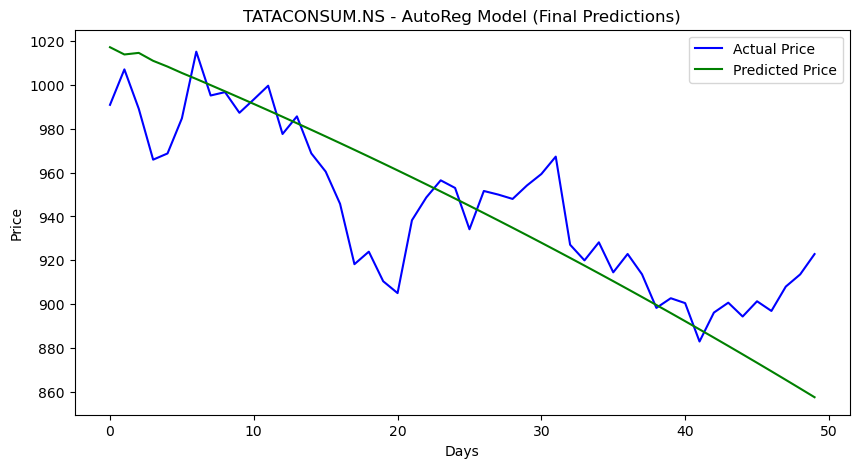

In [3]:
# ========================================================
# 0️⃣ IMPORT LIBRARIES
# ========================================================

import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot as plt


# ========================================================
# 1️⃣ DOWNLOAD DATA
# ========================================================

ticker = yf.Ticker("TATACONSUM.NS")
#stk_data = ticker.history(start="2021-07-01", end="2022-01-28")
stk_data = ticker.history(start="2024-01-01", end="2025-01-03")
print(stk_data)
stk_data.info()


# ========================================================
# 2️⃣ NORMALIZATION (MinMaxScaler)
# ========================================================

column = "Close"
Ms = MinMaxScaler()

data1 = Ms.fit_transform(stk_data[[column]])

print("Len:", data1.shape)


# ========================================================
# 3️⃣ TRAIN–TEST SPLIT (80/20)
# ========================================================

training_size = round(len(data1) * 0.80)
print("Training size:", training_size)

X_train = data1[:training_size]
X_test  = data1[training_size:]

y_train = data1[:training_size]
y_test  = data1[training_size:]

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


# ========================================================
# 4️⃣ AUTOREG MODEL TESTING (All trends & lags)
# ========================================================

trends = ['n', 't', 'c', 'ct']
lags = [1, 2, 3, 4]

results = []

print("\n============================")
print("Training Models...")
print("============================\n")

for lag in lags:
    for tr in trends:

        model = AutoReg(X_train, lags=lag, trend=tr)
        model_fit = model.fit()

        y_pred_scaled = model_fit.predict(len(X_train), len(data1)-1)

        rmse_scaled = np.sqrt(mean_squared_error(y_test, y_pred_scaled))

        print(f"Lag={lag}, Trend={tr}, RMSE(SCALED)={rmse_scaled:.4f}")

        results.append({
            'lag': lag,
            'trend': tr,
            'rmse_scaled': rmse_scaled,
            'model': model_fit
        })


# ========================================================
# 5️⃣ SELECT BEST MODEL
# ========================================================

print("\n============================")
print("Selecting Best Model...")
print("============================")

best_model_info = min(results, key=lambda x: x['rmse_scaled'])

print("\nBEST MODEL FOUND")
print("-----------------")
print(f"Lag   : {best_model_info['lag']}")
print(f"Trend : {best_model_info['trend']}")
print(f"Scaled RMSE : {best_model_info['rmse_scaled']:.4f}")


# ========================================================
# 6️⃣ RETRAIN BEST MODEL ON FULL TRAIN DATA
# ========================================================

best_lag = best_model_info['lag']
best_trend = best_model_info['trend']

final_model = AutoReg(X_train, lags=best_lag, trend=best_trend).fit()

print("\nFinal Best Model Re-trained Successfully!")


# ========================================================
# 7️⃣ FINAL PREDICTIONS (Inverse Transform)
# ========================================================

final_pred_scaled = final_model.predict(len(X_train), len(data1)-1)

# reshape for inverse transform
y_test_scaled = np.array(y_test).reshape(-1,1)
final_pred_scaled = np.array(final_pred_scaled).reshape(-1,1)

# 🔥 Convert scaled → original prices
y_test_real = Ms.inverse_transform(y_test_scaled)
final_pred_real = Ms.inverse_transform(final_pred_scaled)


# ========================================================
# 8️⃣ REAL METRICS (Correct RMSE + MAPE)
# ========================================================

final_rmse_real = np.sqrt(mean_squared_error(y_test_real, final_pred_real))
final_mape_real = mean_absolute_percentage_error(y_test_real, final_pred_real)

print("\nFINAL MODEL PERFORMANCE (REAL PRICES)")
print("--------------------------------------")
print(f"Real RMSE : {final_rmse_real:.4f}")
print(f"Real MAPE : {final_mape_real:.4f}")


# ========================================================
# 9️⃣ PLOT REAL ACTUAL VS PREDICTED PRICES
# ========================================================

def graph(Actual, predicted, Actlabel, predlabel, title, Xlabel, ylabel):
    plt.figure(figsize=(10,5))
    plt.plot(Actual, color='blue', label=Actlabel)
    plt.plot(predicted, color='green', label=predlabel)
    plt.title(title)
    plt.xlabel(Xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


graph(
    y_test_real,
    final_pred_real,
    "Actual Price",
    "Predicted Price",
    "TATACONSUM.NS - AutoReg Model (Final Predictions)",
    "Days",
    "Price"
)


# AutoReg 15-day future forecast module


📈 NEXT 15 DAYS FORECAST (REAL PRICES)

Day +1 : ₹853.48
Day +2 : ₹849.45
Day +3 : ₹845.38
Day +4 : ₹841.29
Day +5 : ₹837.17
Day +6 : ₹833.01
Day +7 : ₹828.83
Day +8 : ₹824.61
Day +9 : ₹820.37
Day +10 : ₹816.09
Day +11 : ₹811.78
Day +12 : ₹807.45
Day +13 : ₹803.08
Day +14 : ₹798.67
Day +15 : ₹794.24


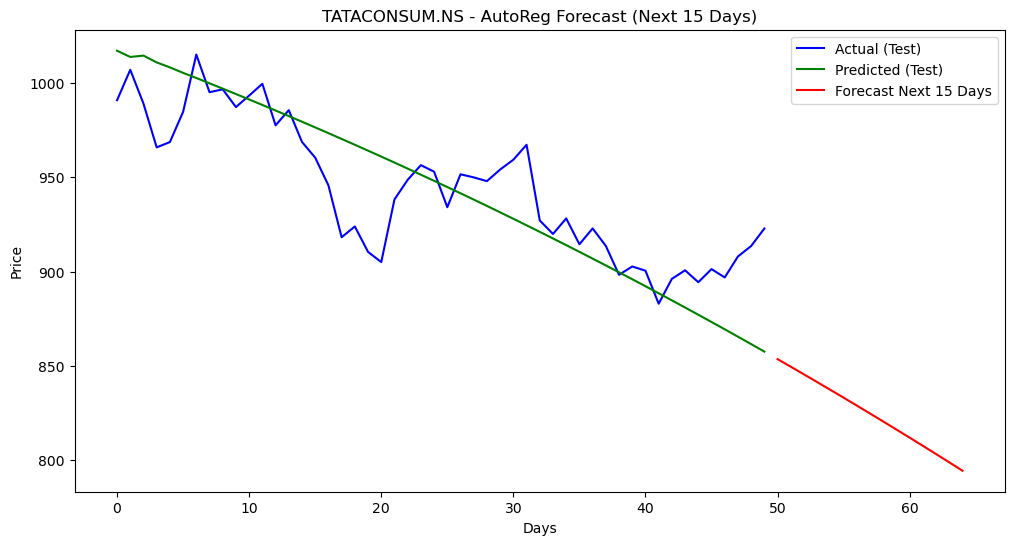

In [4]:
# ========================================================
# 🔮 1️⃣0️⃣ FORECAST NEXT 15 DAYS USING BEST AUTOREG MODEL
# ========================================================

future_steps = 15   # number of days to forecast

# AutoReg requires last 'lag' values from the END of the data
full_data_scaled = data1.flatten()  # all scaled close values

# Use the final model to forecast future values
future_pred_scaled = final_model.predict(
    start=len(full_data_scaled),
    end=len(full_data_scaled) + future_steps - 1
)

# reshape for inverse transform
future_pred_scaled = np.array(future_pred_scaled).reshape(-1, 1)

# Inverse scale → real stock prices
future_pred_real = Ms.inverse_transform(future_pred_scaled)

print("\n============================")
print("📈 NEXT 15 DAYS FORECAST (REAL PRICES)")
print("============================\n")

for i, price in enumerate(future_pred_real):
    print(f"Day +{i+1} : ₹{price[0]:.2f}")


# --------------------------------------------------------
# 📊 PLOT FORECAST VS LAST TEST VALUES
# --------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label='Actual (Test)', color='blue')
plt.plot(final_pred_real, label='Predicted (Test)', color='green')
plt.plot(range(len(y_test_real), len(y_test_real)+future_steps), 
         future_pred_real, 
         label='Forecast Next 15 Days', 
         color='red')

plt.title("TATACONSUM.NS - AutoReg Forecast (Next 15 Days)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()
